In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import ot
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
torch.autograd.set_detect_anomaly(True)

device = "cpu"


In [56]:
n_samples = 200
slope = 1
intercept = 8

## generating non linearly seperable data
D = np.random.uniform(-30, 30, size=(n_samples, 2))

x = np.zeros((2,1))
y = np.zeros(1)

for i in range(D.shape[0]):
    if (D[i,1] < slope*D[i,0] + intercept):
        x = np.append(x,D[i].reshape((2,1)),axis=1)
        y = np.append(y,1)
    else:
        x = np.append(x,D[i].reshape((2,1)),axis=1)
        y = np.append(y,0)

x = x[:,1:]
y = y[1:]

X = torch.from_numpy(x).to(device=device)
Y = torch.from_numpy(y).to(device=device,dtype=torch.int32)
# x[:,5:10].shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


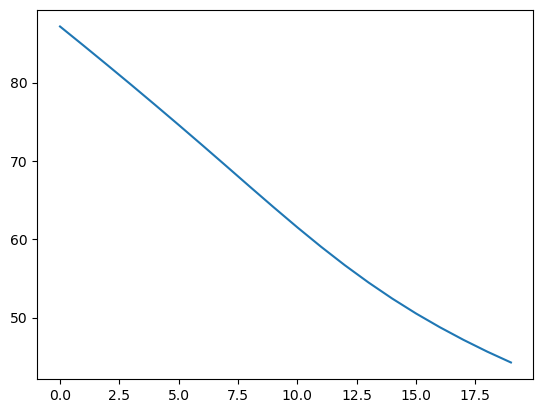

In [65]:
def sinkhorn_fixedCost(batch_a, batch_b, M, reg, stopThr=1e-6, numItermax=1000):
    """
    Sinkhorn Knopp when Cost matrix is common across datapoints
    """
    batch = batch_a.shape[0]
    classes = batch_a.shape[1]

    u = torch.ones((batch, classes)).to(device=device) / classes
    v = torch.ones((batch, classes)).to(device=device) / classes
    K = torch.empty(M.shape, dtype=M.dtype).to(device=device)
    torch.divide(M.to(device=device), -reg, out=K)
    torch.exp(K, out=K)

    # print(batch_b)
    for torcht in range(numItermax):
        KtransposeU = torch.einsum('ij,bi->bj', K, u).to(device=device,dtype=torch.float32)
        v = torch.divide(batch_b, KtransposeU).to(device=device)
        u = 1. / ((1. / (batch_a+1e-6)) * torch.einsum('ij,bj->bi', K, v)).to(device=device)

    gamma = torch.einsum('bi,ij,bj->bij', u, K, v).to(device=device)
    loss = torch.sum(torch.einsum('ijk,jk->i', gamma, M)).to(device=device)
    return loss, gamma, u

input_size = 2
hidden_sizes = [128, 64]
output_size = 2

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1],
                                 output_size),
                      nn.Softmax(dim=1)).to(device=device)
# model.load_state_dict(torch.load("model.pt", map_location=torch.device(device=device)))

optimizer = optim.Adam(model.parameters(),lr=1e-6)
epochs = 20


one2two = torch.arange(2).reshape((2,1)).to(dtype=torch.float32)
C = torch.cdist(one2two,one2two,p=1.0).to(device=device)


def WassersteinLoss(xv,yv,C,reg):
#     loss,gamma, u = sinkhorn_fixedCost(xv,yv,C,reg)
#     print(xv[0],yv)
    loss = ot.sinkhorn2(xv[0],yv,C,reg,method='sinkhorn_log')
    return loss

criterion = WassersteinLoss


f = open('sinkhornot.txt','w')
losses = []

for e in range(epochs):
    running_loss = 0
    for i in range(X.shape[1]):
        xinp = X[:,i].reshape(-1,2).to(dtype=torch.float32)
#         print(xinp)
        optimizer.zero_grad()
        output = model(xinp)
        loss = criterion(output, torch.eye(2)[Y[i]].to(device=device),C,0.0020)
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        # print(e,i, loss)
    print(e,running_loss,file=f)
    print(e)
    losses.append(running_loss.to(device='cpu').detach().numpy())

plt.plot(np.arange(epochs),losses)
plt.savefig("EPOCHVSLOSSES.png")
torch.save(model.state_dict(),"sinkhornmodel.pt")
preds=0
